In [ ]:
!pip install langgraph
!pip install langchain langchain_groq langchain_community
!pip install pyowm

In [2]:
from google.colab import userdata
groq_api_key=userdata.get('groq_api_key')
from langchain_groq import ChatGroq
from langgraph.graph import Graph

workflow = Graph()
model=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-groq-70b-8192-tool-use-preview")
from langchain_community.utilities import OpenWeatherMapAPIWrapper
import os
os.environ["OPENWEATHERMAP_API_KEY"] = "OPENWEATHERMAP_API_KEY"
weather = OpenWeatherMapAPIWrapper()

In [3]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide only the city name based on the user query. \
                    Nothing more, just the city name mentioned. Following is the user query: " + user_input
    response = model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = "Your task is to provide info concisely based on the user query and the available information from the internet. \
                        Following is the user query: " + user_input + " Available information: " + available_info
    response = model.invoke(agent2_query)
    return response.content

In [4]:
from langgraph.graph import Graph

workflow = Graph()


workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()

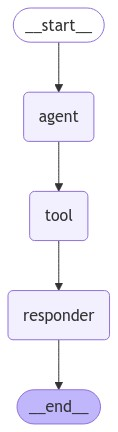

In [5]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [6]:
inputs = {"messages": ["what is the temperature in Bangalore"]}
app.invoke(inputs)

'The current temperature in Bangalore is 23.49°C.'